# 01/12/24 - Shawn Knabel
## Developing iterative background-source fitting between the central deflector spectrum and background source spectrum.

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pathlib # to create directory
import dill as pickle
from datetime import datetime
import os

from ppxf.ppxf import ppxf
from pathlib import Path
from scipy import ndimage
from urllib import request
from scipy import ndimage
from time import perf_counter as clock
from scipy import interpolate
from astropy.visualization import simple_norm
from astropy.modeling.models import Sersic2D
import astropy.units as u
from vorbin.voronoi_2d_binning import voronoi_2d_binning

import ppxf.ppxf_util as ppxf_util
from os import path
ppxf_dir = path.dirname(path.realpath(ppxf_util.__file__))
import ppxf.sps_util as sps_util


# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages/ppxf_kcwi_util_022423")

from slacs_kcwi_kinematics import slacs_kcwi_kinematics

In [2]:
c = 299792.458 # km/s

In [3]:
#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

In [4]:
# Universal parameters
# todays date
date = datetime.now().strftime("%Y_%m_%d")
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
kinematics_dir = f'{data_dir}kinematics/{date}/'
if not os.path.exists(kinematics_dir):
    os.mkdir(kinematics_dir)
#------------------------------------------------------------------------------
# Kinematics systematics initial choices
# aperture
aperture = 'R2'
# wavelength range
wave_min = 3400
wave_max = 4300 ########### NOTE J0330 will be different
# degree of the additive Legendre polynomial in ppxf
degree = 4 # 900/250 = 3.6 round up
#------------------------------------------------------------------------------
# Information specific to KCWI and templates
kcwi_scale = 0.1457
## R=3600. spectral resolution is ~ 1.42A
FWHM = 1.42 #1.42
## initial estimate of the noise
noise = 0.014
# velocity scale ratio
velscale_ratio = 2
#------------------------------------------------------------------------------
# variable settings in ppxf and utility functions
# cut the datacube at lens center, radius given here
radius_in_pixels = 21
# target SN for voronoi binning
#vorbin_SN_targets = np.array([10, 15, 20])
bin_target_SN = 15.
# minimum SN of pixels to be included in voronoi bining
pixel_min_SN = 1.
# stellar population
sps_name = 'emiles'


__________
# J0029

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0029-0055'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.227 # lens redshift
T_exp = 1800*5 # exposure time in seconds... this is where I made the disastrous mistake
lens_center_x,lens_center_y = 61, 129
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'

mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [ ]:
j0029_kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                    a         wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
f'{os.getcwd()}/data/'

In [ ]:
os.getcwd()

In [ ]:
j0029_kinematics.run_slacs_kcwi_kinematics(fit_poisson_noise=False, plot_bin_fits=False)

In [ ]:
questions = [29,
                30,
                31,
                32,
                35,
                42,
                56,
                75,
                90,
                94,
                95
            ]

In [ ]:
qs = j0029_kinematics.voronoi_binning_output[np.isin(j0029_kinematics.voronoi_binning_output[:,2], questions)]

In [ ]:
plt.imshow(j0029_kinematics.VD_2d, origin='lower')
plt.scatter(qs[:,0], qs[:,1], c=qs[:,2], cmap='sauron')
plt.colorbar()

In [ ]:
obj_names

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}SDSSJ0029-0055_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j0029_kinematics, file)

__________
# J0037

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0037-0942'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.195 # lens redshift
T_exp = 1800*3 # This has been corrected
lens_center_x,lens_center_y = 59, 137
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [ ]:
j0037_kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j0037_kinematics.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [106,
                110,
                117,
                143,
                150,
                151,
                153,
                163,
                165
            ]

In [ ]:
qs = j0037_kinematics.voronoi_binning_output[np.isin(j0037_kinematics.voronoi_binning_output[:,2], questions)]

In [ ]:
plt.imshow(j0037_kinematics.VD_2d, origin='lower')
plt.scatter(qs[:,0], qs[:,1], c=qs[:,2], cmap='sauron')
plt.colorbar()

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j0037_kinematics, file)

# J0330

In [61]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0330-0020'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.351 # lens redshift
#z_bs = 1.071 # background source redshift... additional piece for contamination
exp_time = 1800*6 # fixed
lens_center_x,lens_center_y = 59, 133
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
#------------------------------------------------------------------------------
# Kinematics systematics initial choices
# wavelength range
wave_min_j0330 = 3400
wave_max_j0330 = 4100 # shorter wave range because higher redshift
# degree of the additive Legendre polynomial in ppxf
degree_j0330 = 7#3 # 70/25 = 2.8 round up
#------------------------------------------------------------------------------
#KCWI mosaic datacube
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [62]:
j0330_kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=background_spectrum_file,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=exp_time,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min_j0330, # diff because higher redshift cuts off above 4100 A
                                             wave_max=wave_max_j0330,
                                             degree=degree_j0330,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
)

# Now let's add a method to the class instance that will do what we want.

In [63]:
from types import MethodType

In [64]:
# make a function to prepare background source 

#########################################

def log_rebin_background_source_spectrum(self):
    '''
    Function to deredshift and rebin the background source galaxy spectrum to log space and prepare the restframe wavelengths for proper fitting with the stellar template spectra later.
    '''

    # open the fits file and get the data
    hdu = fits.open(self.background_spectrum_file)

    # background source galaxy spectrum with linear wavelength spacing
    gal_lin = hdu[0].data
    h1 = hdu[0].header

    # wavelength range from fits header
    lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)])

    # Compute approximate restframe wavelength range
    self.bg_src_rest_wave_range = lamRange1/(1+self.zlens)

    # Adjust resolution in Angstrom
    self.bg_src_rest_FWHM = self.FWHM/(1+self.zlens)  

    # rebin to log wavelengths and calculate velocity scale (resolution)
    self.background_source_spectrum, self.bg_src_rest_wave_log, self.bg_src_velscale = \
                                        ppxf_util.log_rebin(self.bg_src_rest_wave_range, gal_lin)

    # keep the rebinned wavelengths in Angstroms
    self.bg_src_rest_wave = np.exp(self.bg_src_rest_wave_log)


In [65]:
zsource = 1.071 # background source redshift... additional piece for contamination
j0330_kinematics.zsource = zsource

In [66]:
# make a function to prepare the templates for the background source

def get_templates_two_component(self):
        '''
        Function prepares the stellar template spectra from the sps model identified by sps_name.
        '''
        
        # take wavelength range of templates to be slightly larger than that of the galaxy restframe
        self.wave_range_templates = self.rest_wave_range[0]/1.1, self.rest_wave_range[1]*1.1
        # background source templates need to be redshifted from the restframe of the lens
        #zdiff = self.zsource-self.zlens
        z_ratio = (1+self.zsource)/(1+self.zlens)
        #bg_src_wave_range_templates = self.rest_wave_range[0]/1.1/(1+zdiff), self.rest_wave_range[1]*1.1/(1+zdiff)
        bg_src_wave_range_templates = self.rest_wave_range[0]/1.1/z_ratio, self.rest_wave_range[1]*1.1/z_ratio
        print('lens rest wavves', self.wave_range_templates)
        print('bg src rest waves', bg_src_wave_range_templates)
        
        # bring in the templates from ppxf/sps_models/
        basename = f"spectra_{self.sps_name}_9.0.npz"
        filename = path.join(ppxf_dir, 'sps_models', basename)
        
        # templates for lens deflector galaxy fit
        # template library will be sampled at data resolution times the velscale_ratio in the given wavelength range
        lens_sps = sps_util.sps_lib(filename, 
                               self.central_velscale/self.velscale_ratio, # resolution
                               self.rest_FWHM, # data FWHM in restframe
                               wave_range=self.wave_range_templates) # range for templates
        lens_templates= lens_sps.templates
        lens_templates = lens_templates.reshape(lens_templates.shape[0], -1)
        lens_templates_wave = lens_sps.lam_temp
        n_templates = lens_templates.shape[1]
        self.n_templates = n_templates
        for i in range(5):
            plt.plot(lens_templates_wave, lens_templates[:,10*i])
        
        # templates for background source galaxy
        bg_src_sps = sps_util.sps_lib(filename, 
                               self.central_velscale/self.velscale_ratio,#/(1+zdiff), # resolution
                               self.rest_FWHM/z_ratio,#(1+zdiff), # data FWHM in restframe
                               wave_range=bg_src_wave_range_templates) # range for templates
        bg_src_templates = bg_src_sps.templates
        bg_src_templates = bg_src_templates.reshape(bg_src_templates.shape[0], -1)
        bg_src_templates_wave = bg_src_sps.lam_temp * z_ratio#(1+zdiff)
        for i in range(5):
            plt.plot(bg_src_templates_wave, bg_src_templates[:,10*i])
        plt.pause(1)
        if bg_src_templates_wave[0] > self.wave_range_templates[0]:
            print('Templates do not go to small enough wavelength to be deredshifted from background source.')
            # then the length of the background source templates will also not be correct. add nans
            print('bgs templates wavelengths',bg_src_templates_wave.size, bg_src_templates_wave)
            add_ind = lens_templates_wave.size - bg_src_templates_wave.size
            print(f'Adding {add_ind} nans to fill out array size.')
            wavelength_interval = bg_src_templates_wave[1] - bg_src_templates_wave[0]
            add_wavelengths = np.empty(add_ind) * 0#np.nan #bg_src_templates_wave[1] - np.arange(1, 1+add_ind)[::-1] * wavelength_interval
            add_nans = np.empty((add_ind, n_templates)) * 0#np.nan
            bg_src_templates_wave = np.concatenate((add_wavelengths, bg_src_templates_wave))
            bg_src_templates = np.concatenate((add_nans, bg_src_templates))
        
        print('bg source wavelengths', bg_src_templates_wave.size, bg_src_templates_wave)#
        #print('bg source wavelengths redshifted', bg_src_templates_wave*(1+zdiff))
            
        # stack the two together
        self.templates = np.hstack((lens_templates, bg_src_templates))
        # normalize
        self.templates /= np.nanmedian(self.templates, 0)
        # assign templates to the 0th and 1st components (lens deflector and background source)
        self.templates_components = np.concatenate( (
                                                        np.zeros(n_templates, dtype=int), 
                                                        np.ones(n_templates, dtype=int)
                                                    )
                                                )
        self.templates_wave = lens_templates_wave

In [67]:
# add the two fucntions above to the instance
j0330_kinematics.log_rebin_background_source_spectrum = MethodType(log_rebin_background_source_spectrum, j0330_kinematics)
j0330_kinematics.get_templates_two_component = MethodType(get_templates_two_component, j0330_kinematics)

In [68]:
# make a function like ppxf_central_spectrum

def ppxf_central_and_background_spectra_two_component(self):
        '''
        Function fits the central_spectrum with the stellar template spectra, a polynomial of specified degree, and the background source as the "sky" component.
        '''
        
        chi2s = []
        
        '''
        First central fit
        '''
        # some setup, starting guesses
        moments = [2, 2]
        vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
        start = [[vel, 250.], [vel, 100.]]  # (km/s), starting guess for [V, sigma]
        bounds = [
                    [[-200, 200],[50, 450]], # foreground
                    [[-500, 500],[50, 450]] # background
                    ]
        t = clock()
        
        # create a noise array # Assume constant noise per AA
        noise_array = np.full_like(self.central_spectrum, self.noise) 
        
        # fit with ppxf
        pp = ppxf(self.templates, # templates for fitting
                  self.central_spectrum,  # spectrum to be fit
                  noise_array,
                  self.central_velscale, # resolution
                  start, # starting guess
                  plot=False, # no need to plot here, will plot after
                  component=self.templates_components, # indicates which components are used for which kinematic component (lens and bg source)
                  moments=moments, # VD and V, no others
                  bounds=bounds,
                  goodpixels=self.mask, # mask we made
                  degree=self.degree, # degree of polynomial we specified
                  velscale_ratio=self.velscale_ratio, # resolution of templates wrt. data
                  sky=None,#self.background_spectrum, # background source spectrum
                  lam=self.rest_wave, # wavelengths for fitting
                  lam_temp=self.templates_wave, # wavelenghts of templates
                 )

        #plot the fit
        # model
        model = pp.bestfit
        # background source
        #background = self.background_spectrum * pp.weights[-1]
        # data
        data = pp.galaxy
        # lens templates
        # use the templates instead of the templates from input instead of those output by ppxf
        lens_templates = self.templates[:,:self.n_templates] @ pp.weights[:self.n_templates]
        self.lens_templates = lens_templates
        temp_lin_axis = np.linspace(self.templates_wave[0], self.templates_wave[-1], self.templates_wave.size)
        # bg_src templates
        bg_src_templates = self.templates[:,self.n_templates:] @ pp.weights[self.n_templates:]
        # polynomial
        polynomial = pp.apoly
        
        # linearize the wavelengths for plotting
        log_axis = self.rest_wave
        lin_axis = np.linspace(self.rest_wave_range[0], self.rest_wave_range[1], data.size)
        
        # rebin in linear space
        #back_lin = de_log_rebin(log_axis, background, lin_axis) # background source fit
        model_lin = de_log_rebin(log_axis, model, lin_axis) # ppxf model
        data_lin = de_log_rebin(log_axis, data, lin_axis) # data
        noise_lin = data_lin - model_lin # noise
        lens_lin = de_log_rebin(self.templates_wave, lens_templates, temp_lin_axis)
        bg_src_lin = de_log_rebin(self.templates_wave, bg_src_templates, temp_lin_axis)
        poly_lin = de_log_rebin(log_axis, polynomial, lin_axis)
        
        # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
        plot_ind_min = find_nearest(lin_axis, self.wave_min)
        plot_ind_max = find_nearest(lin_axis, self.wave_max)
        
        # make the figure
        plt.figure(figsize=(8,6))
        
        # plot the spectra, noise, etc
        plt.plot(lin_axis, data_lin, 'k-', label='data')
        plt.plot(lin_axis, model_lin, 'r-', label='model (lens+background)')
        plt.plot(temp_lin_axis, lens_lin, 'm-',
                 label='lens', alpha=0.5) # if there is a background source to remove
        plt.plot(temp_lin_axis, bg_src_lin, 'b-',
                 label='bg src', alpha=0.5)
        plt.plot(lin_axis, poly_lin, 'c-',
                 label='polynomial', alpha=0.5)
        #plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
        plt.plot(lin_axis, noise_lin, 'g-',# + np.full_like(noise_lin, 0.9e-5), 'g-',
                 label='noise (data - best model)', alpha=0.7)
        
        
        # set labels, axes, etc
        plt.legend(loc='best')
        plt.ylim(np.nanmin(poly_lin[plot_ind_min:plot_ind_max]), np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
        plt.xlim(self.wave_min, self.wave_max)
        plt.xlabel('wavelength (A)')
        plt.ylabel('relative flux')
        plt.title(f'Velocity dispersion - {pp.sol[0][1]} km/s')
        plt.show()
        plt.pause(1)
        
        # plot templates of foreground fit
        for i in range(self.n_templates):
            if pp.weights[i] != 0:
                # plot the template
                plt.plot(temp_lin_axis, self.templates[:,i] * pp.weights[i])
        plt.title('foreground deflector')
        plt.pause(1)
        
        # plot background source
        # plot templates of foreground fit
        for i in range(self.n_templates,self.n_templates*2):
            if pp.weights[i] != 0:
                # plot the template
                plt.plot(temp_lin_axis, self.templates[:,i] * pp.weights[i])
        plt.title('background source')
        plt.pause(1)
        
        # plot the polynomial
        plt.plot(lin_axis, poly_lin)
        plt.title('additive polynomial')
        plt.pause(1)
        plt.plot(lin_axis, poly_lin)
        plt.xlim(self.wave_min, self.wave_max)
        plt.ylim(np.nanmin(poly_lin[plot_ind_min:plot_ind_max]), np.nanmax(poly_lin[plot_ind_min:plot_ind_max]))
        plt.title('additive polynomial')
        plt.pause(1)
        
        # take chi2
        chi2s.append(pp.chi2)
        

        '''
        First arc fit
        '''
        
        # take the fit for lens from teh previous ppxf, fit the background templates newly
        templates_rev = np.vstack([lens_templates, self.templates[:, self.n_templates:].T]).T
        templates_comp_rev = [0]*1 + [1]*self.n_templates
        
        print('Now fitting the background source arc spectrum')
        # fit with ppxf
        pp = ppxf(templates_rev,#self.templates, # templates for fitting
                  self.background_source_spectrum,  # spectrum to be fit
                  noise_array,
                  self.central_velscale, # resolution
                  start, # starting guess
                  plot=False, # no need to plot here, will plot after
                  component=templates_comp_rev, # indicates which components are used for which kinematic component (lens and bg source)
                  moments=moments, # VD and V, no others
                  bounds=bounds,
                  goodpixels=self.mask, # mask we made
                  degree=self.degree, # degree of polynomial we specified
                  velscale_ratio=self.velscale_ratio, # resolution of templates wrt. data
                  sky=None,#self.background_spectrum, # background source spectrum
                  lam=self.rest_wave, # wavelengths for fitting
                  lam_temp=self.templates_wave, # wavelenghts of templates
                 )

        
        #plot the fit
        # model
        model = pp.bestfit
        # background source
        #background = self.background_spectrum * pp.weights[-1]
        # data
        data = pp.galaxy
        # lens templates
        # use the templates instead of the templates from input instead of those output by ppxf
        #bigbigbug
        lens_templates = templates_rev[:,0] * pp.weights[0]
        # bg_src templates
        bg_src_templates = templates_rev[:,1:] @ pp.weights[1:]
        # polynomial
        polynomial = pp.apoly
        
        # linearize the wavelengths for plotting
        log_axis = self.rest_wave
        lin_axis = np.linspace(self.rest_wave_range[0], self.rest_wave_range[1], data.size)
        
        # rebin in linear space
        #back_lin = de_log_rebin(log_axis, background, lin_axis) # background source fit
        model_lin = de_log_rebin(log_axis, model, lin_axis) # ppxf model
        data_lin = de_log_rebin(log_axis, data, lin_axis) # data
        noise_lin = data_lin - model_lin # noise
        lens_lin = de_log_rebin(self.templates_wave, lens_templates, temp_lin_axis)
        bg_src_lin = de_log_rebin(self.templates_wave, bg_src_templates, temp_lin_axis)
        poly_lin = de_log_rebin(log_axis, polynomial, lin_axis)
        
        # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
        plot_ind_min = find_nearest(lin_axis, self.wave_min)
        plot_ind_max = find_nearest(lin_axis, self.wave_max)
        
        # make the figure
        plt.figure(figsize=(8,6))
        
        # plot the spectra, noise, etc
        plt.plot(lin_axis, data_lin, 'k-', label='data')
        plt.plot(lin_axis, model_lin, 'r-', label='model (lens+background)')
        plt.plot(temp_lin_axis, lens_lin, 'm-',
                 label='lens', alpha=0.5) # if there is a background source to remove
        plt.plot(temp_lin_axis, bg_src_lin, 'b-',
                 label='bg src', alpha=0.5)
        plt.plot(lin_axis, poly_lin, 'c-',
                 label='polynomial', alpha=0.5)
        #plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
        plt.plot(lin_axis, noise_lin, 'g-',# + np.full_like(noise_lin, 0.9e-5), 'g-',
                 label='noise (data - best model)', alpha=0.7)
        
        
        # set labels, axes, etc
        plt.legend(loc='best')
        plt.ylim(np.nanmin(poly_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
        plt.xlim(self.wave_min, self.wave_max)
        plt.xlabel('wavelength (A)')
        plt.ylabel('relative flux')
        plt.title(f'Velocity dispersion - {pp.sol[0][1]} km/s')
        plt.show()
        plt.pause(1)
        
        plt.plot(temp_lin_axis, bg_src_lin, 'b-',
                 label='bg src', alpha=0.5)
        plt.title('background source')
        plt.pause(1)
        
        chi2s.append(pp.chi2)
        
        '''
        Second central fit
        '''
        
        # take the fit for lens from teh previous ppxf, fit the background templates newly
        templates_rev = np.vstack([self.templates[:, :self.n_templates].T, bg_src_templates]).T
        templates_comp_rev = [0]*self.n_templates + [1]*1#self.n_templates
        
        print('Now fitting the central spectrum')
        # fit with ppxf
        pp = ppxf(templates_rev,#self.templates, # templates for fitting
                  self.central_spectrum,  # spectrum to be fit
                  noise_array,
                  self.central_velscale, # resolution
                  start, # starting guess
                  plot=False, # no need to plot here, will plot after
                  component=templates_comp_rev, # indicates which components are used for which kinematic component (lens and bg source)
                  moments=moments, # VD and V, no others
                  bounds=bounds,
                  goodpixels=self.mask, # mask we made
                  degree=self.degree, # degree of polynomial we specified
                  velscale_ratio=self.velscale_ratio, # resolution of templates wrt. data
                  sky=None,#self.background_spectrum, # background source spectrum
                  lam=self.rest_wave, # wavelengths for fitting
                  lam_temp=self.templates_wave, # wavelenghts of templates
                 )

        
        #plot the fit
        # model
        model = pp.bestfit
        # background source
        #background = self.background_spectrum * pp.weights[-1]
        # data
        data = pp.galaxy
        # lens templates
        # use the templates instead of the templates from input instead of those output by ppxf
        lens_templates = templates_rev[:,:self.n_templates] @ pp.weights[:self.n_templates]
        # bg_src templates
        bg_src_templates = templates_rev[:,-1] * pp.weights[-1]
        # polynomial
        polynomial = pp.apoly
        
        # linearize the wavelengths for plotting
        log_axis = self.rest_wave
        lin_axis = np.linspace(self.rest_wave_range[0], self.rest_wave_range[1], data.size)
        
        # rebin in linear space
        #back_lin = de_log_rebin(log_axis, background, lin_axis) # background source fit
        model_lin = de_log_rebin(log_axis, model, lin_axis) # ppxf model
        data_lin = de_log_rebin(log_axis, data, lin_axis) # data
        noise_lin = data_lin - model_lin # noise
        lens_lin = de_log_rebin(self.templates_wave, lens_templates, temp_lin_axis)
        bg_src_lin = de_log_rebin(self.templates_wave, bg_src_templates, temp_lin_axis)
        poly_lin = de_log_rebin(log_axis, polynomial, lin_axis)
        
        # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
        plot_ind_min = find_nearest(lin_axis, self.wave_min)
        plot_ind_max = find_nearest(lin_axis, self.wave_max)
        
        # make the figure
        plt.figure(figsize=(8,6))
        
        # plot the spectra, noise, etc
        plt.plot(lin_axis, data_lin, 'k-', label='data')
        plt.plot(lin_axis, model_lin, 'r-', label='model (lens+background)')
        plt.plot(temp_lin_axis, lens_lin, 'm-',
                 label='lens', alpha=0.5) # if there is a background source to remove
        plt.plot(temp_lin_axis, bg_src_lin, 'b-',
                 label='bg src', alpha=0.5)
        plt.plot(lin_axis, poly_lin, 'c-',
                 label='polynomial', alpha=0.5)
        #plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
        plt.plot(lin_axis, noise_lin, 'g-',# + np.full_like(noise_lin, 0.9e-5), 'g-',
                 label='noise (data - best model)', alpha=0.7)
        
        
        # set labels, axes, etc
        plt.legend(loc='best')
        plt.ylim(np.nanmin(noise_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
        plt.xlim(self.wave_min, self.wave_max)
        plt.xlabel('wavelength (A)')
        plt.ylabel('relative flux')
        plt.title(f'Velocity dispersion - {pp.sol[0][1]} km/s')
        plt.show()
        plt.pause(1)
        
        plt.plot(temp_lin_axis, bg_src_lin, 'b-',
                 label='bg src', alpha=0.5)
        plt.title('background source')
        plt.pause(1)
        
        chi2s.append(pp.chi2)
        
        '''
        Second arc fit
        '''
        
        # take the fit for lens from teh previous ppxf, fit the background templates newly
        templates_rev = np.vstack([lens_templates, self.templates[:, self.n_templates:].T]).T
        templates_comp_rev = [0]*1 + [1]*self.n_templates
        
        print('Now fitting the background source arc spectrum')
        # fit with ppxf
        pp = ppxf(templates_rev,#self.templates, # templates for fitting
                  self.background_source_spectrum,  # spectrum to be fit
                  noise_array,
                  self.central_velscale, # resolution
                  start, # starting guess
                  plot=False, # no need to plot here, will plot after
                  component=templates_comp_rev, # indicates which components are used for which kinematic component (lens and bg source)
                  moments=moments, # VD and V, no others
                  bounds=bounds,
                  goodpixels=self.mask, # mask we made
                  degree=self.degree, # degree of polynomial we specified
                  velscale_ratio=self.velscale_ratio, # resolution of templates wrt. data
                  sky=None,#self.background_spectrum, # background source spectrum
                  lam=self.rest_wave, # wavelengths for fitting
                  lam_temp=self.templates_wave, # wavelenghts of templates
                 )

        
        #plot the fit
        # model
        model = pp.bestfit
        # background source
        #background = self.background_spectrum * pp.weights[-1]
        # data
        data = pp.galaxy
        # lens templates
        # use the templates instead of the templates from input instead of those output by ppxf
        lens_templates = templates_rev[:,0] * pp.weights[0]
        # bg_src templates
        bg_src_templates = templates_rev[:,1:] @ pp.weights[1:]
        # polynomial
        polynomial = pp.apoly
        
        # linearize the wavelengths for plotting
        log_axis = self.rest_wave
        lin_axis = np.linspace(self.rest_wave_range[0], self.rest_wave_range[1], data.size)
        
        # rebin in linear space
        #back_lin = de_log_rebin(log_axis, background, lin_axis) # background source fit
        model_lin = de_log_rebin(log_axis, model, lin_axis) # ppxf model
        data_lin = de_log_rebin(log_axis, data, lin_axis) # data
        noise_lin = data_lin - model_lin # noise
        lens_lin = de_log_rebin(self.templates_wave, lens_templates, temp_lin_axis)
        bg_src_lin = de_log_rebin(self.templates_wave, bg_src_templates, temp_lin_axis)
        poly_lin = de_log_rebin(log_axis, polynomial, lin_axis)
        
        # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
        plot_ind_min = find_nearest(lin_axis, self.wave_min)
        plot_ind_max = find_nearest(lin_axis, self.wave_max)
        
        # make the figure
        plt.figure(figsize=(8,6))
        
        # plot the spectra, noise, etc
        plt.plot(lin_axis, data_lin, 'k-', label='data')
        plt.plot(lin_axis, model_lin, 'r-', label='model (lens+background)')
        plt.plot(temp_lin_axis, lens_lin, 'm-',
                 label='lens', alpha=0.5) # if there is a background source to remove
        plt.plot(temp_lin_axis, bg_src_lin, 'b-',
                 label='bg src', alpha=0.5)
        plt.plot(lin_axis, poly_lin, 'c-',
                 label='polynomial', alpha=0.5)
        #plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
        plt.plot(lin_axis, noise_lin, 'g-',# + np.full_like(noise_lin, 0.9e-5), 'g-',
                 label='noise (data - best model)', alpha=0.7)
        
        
        # set labels, axes, etc
        plt.legend(loc='best')
        plt.ylim(np.nanmin(noise_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
        plt.xlim(self.wave_min, self.wave_max)
        plt.xlabel('wavelength (A)')
        plt.ylabel('relative flux')
        plt.title(f'Velocity dispersion - {pp.sol[0][1]} km/s')
        plt.show()
        plt.pause(1)
        
        plt.plot(temp_lin_axis, bg_src_lin, 'b-',
                 label='bg src', alpha=0.5)
        plt.title('background source')
        plt.pause(1)
        
        chi2s.append(pp.chi2)
        
        print('chi2s', chi2s)
        
        # take the fit as attributes for future
        self.central_spectrum_ppxf = pp
        # number of templates
        self.nTemplates = pp.templates.shape[1]
        # global_template is what we use to fit the bins
        self.global_template = pp.templates @ pp.weights[:self.nTemplates]
        self.global_template_wave = pp.lam_temp

In [69]:
# add it to the class instnace

j0330_kinematics.ppxf_central_and_background_spectra_two_component = \
                            MethodType(ppxf_central_and_background_spectra_two_component, j0330_kinematics)

lens rest wavves (2239.7550635892603, 4833.160621761658)
bg src rest waves (1461.085992713226, 3152.873008208595)


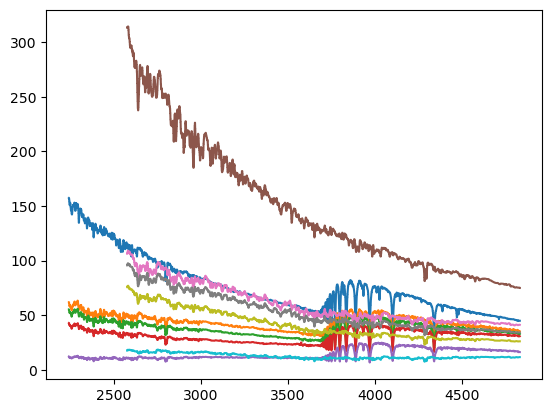

Templates do not go to small enough wavelength to be deredshifted from background source.
bgs templates wavelengths 11352 [2575.02496629 2575.16779898 2575.31063958 ... 4832.44901768 4832.71706621
 4832.98512961]
Adding 2515 nans to fill out array size.
bg source wavelengths 13867 [   0.            0.            0.         ... 4832.44901768 4832.71706621
 4832.98512961]


/tmp/ipykernel_1000070/1994852859.py:55: RuntimeWarning: invalid value encountered in multiply
  add_nans = np.empty((add_ind, n_templates)) * 0#np.nan


In [70]:
# rebin the central spectrum in log wavelengths and prepare for fitting
j0330_kinematics.log_rebin_central_spectrum()
j0330_kinematics.log_rebin_background_source_spectrum()
# prepare the templates from the sps model
j0330_kinematics.get_templates_two_component()

In [71]:
# steps before the ppxf step
# set up the wavelengths that will be fit, masks a couple gas lines
j0330_kinematics.set_up_mask()
#j0330_kinematics.log_rebin_background_spectrum()

In [72]:
j0330_kinematics.templates_components.shape

(300,)

In [73]:
j0330_kinematics.templates.shape

(13867, 300)

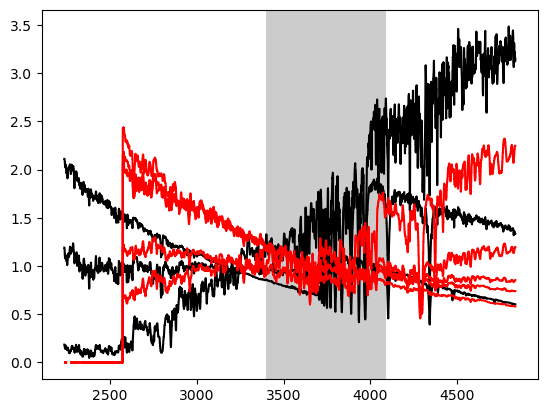

In [74]:
plt.plot(j0330_kinematics.templates_wave, j0330_kinematics.templates[:,0:150:50], c='k')
plt.plot(j0330_kinematics.templates_wave, j0330_kinematics.templates[:,150:300:30], c='r')
plt.axvspan(j0330_kinematics.rest_wave[j0330_kinematics.mask][0], j0330_kinematics.rest_wave[j0330_kinematics.mask][-1], facecolor='k', alpha=0.2)

In [75]:
j0330_kinematics.templates_components[::50]

array([0, 0, 0, 1, 1, 1])

j0330_kinematics.templates=j0330_kinematics.templates[:,:150]
j0330_kinematics.templates_components=j0330_kinematics.templates_components[:150]
j0330_kinematics.templates_components[75:]=1

In [76]:
def de_log_rebin(delog_axi, value, lin_axi):
    '''
    :param delog_axi: input the value by np.exp(logLam1)
    :param value: flux at the location of np.exp(logLam1) array
    :param lin_axi: linear space in wavelength that we want to intepolate
    :return: flux at the location of linear space in wavelength
    '''
    inte_sky = interpolate.interp1d(delog_axi, value, bounds_error=False)
    sky_lin = inte_sky(lin_axi)
    return sky_lin

In [77]:
def find_nearest(array, value):
    '''000000000000000000000000000000000000000000000
    :param array: wavelength array
    :param value: wavelength that we want to get the index
    :return: the index of the wavelength
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

 Best Fit:       Vel     sigma
 comp.  0:        83       239
 comp.  1:       -76        50
chi2/DOF: 0.1424; DOF: 1566; degree = 7; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/300


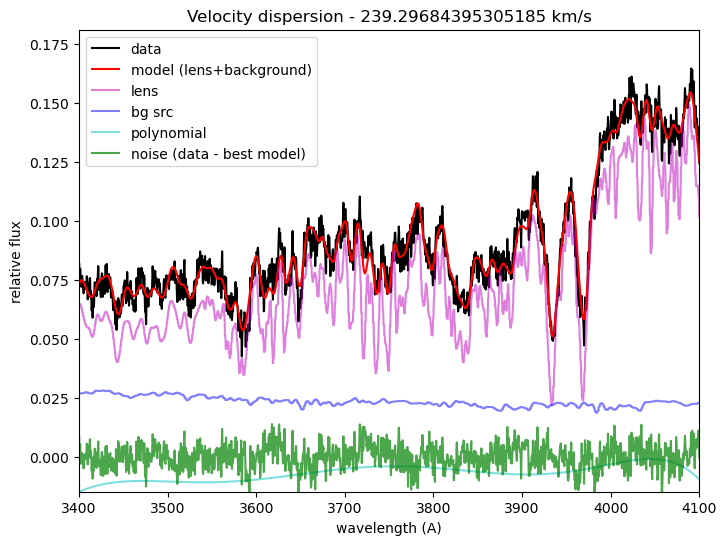

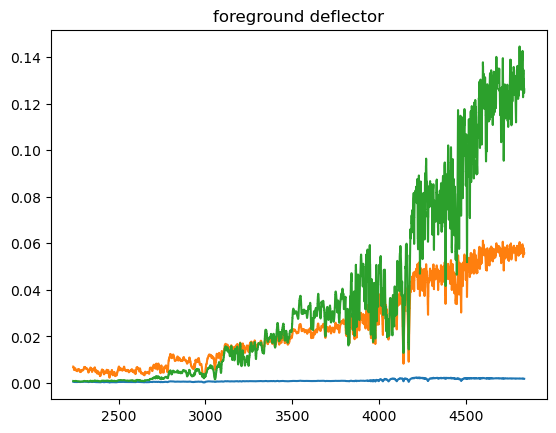

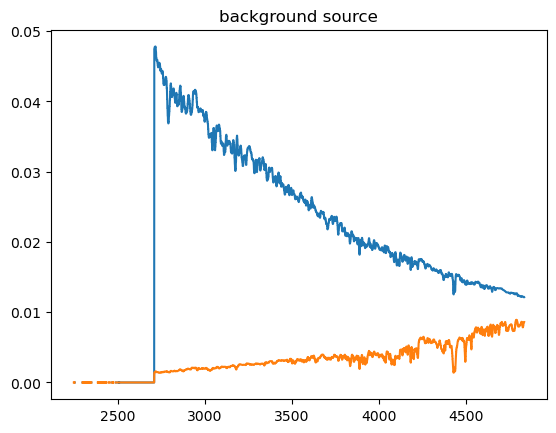

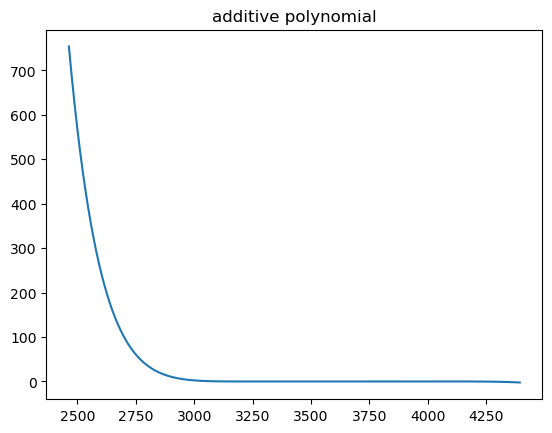

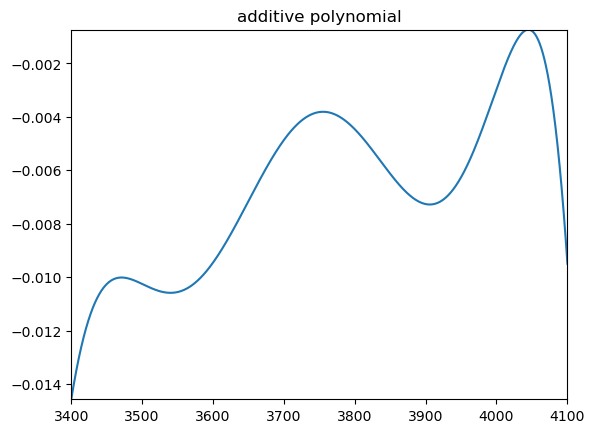

Now fitting the background source arc spectrum
 Best Fit:       Vel     sigma
 comp.  0:       200       450
 comp.  1:      -135        50
chi2/DOF: 0.04440; DOF: 1566; degree = 7; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/151


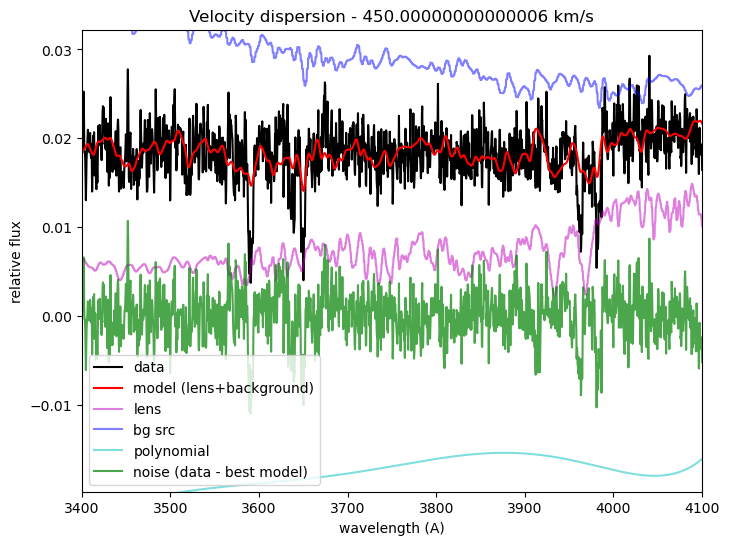

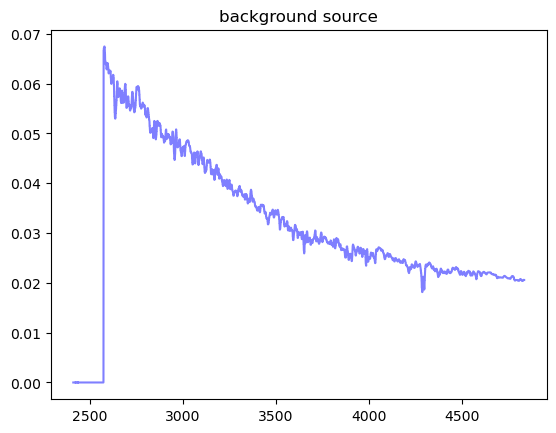

Now fitting the central spectrum
 Best Fit:       Vel     sigma
 comp.  0:        84       239
 comp.  1:       -62        50
chi2/DOF: 0.1427; DOF: 1566; degree = 7; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/151


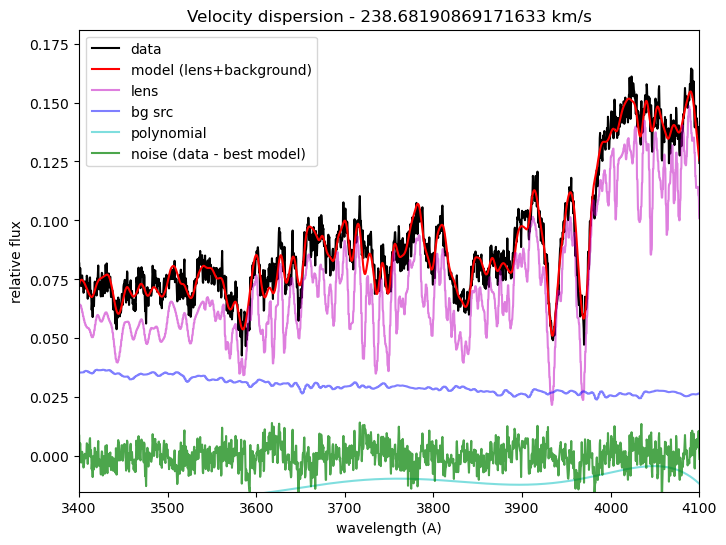

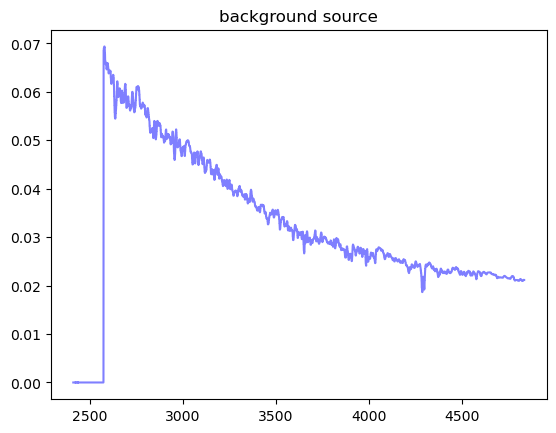

Now fitting the background source arc spectrum
 Best Fit:       Vel     sigma
 comp.  0:       200       450
 comp.  1:      -135        50
chi2/DOF: 0.04440; DOF: 1566; degree = 7; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/151


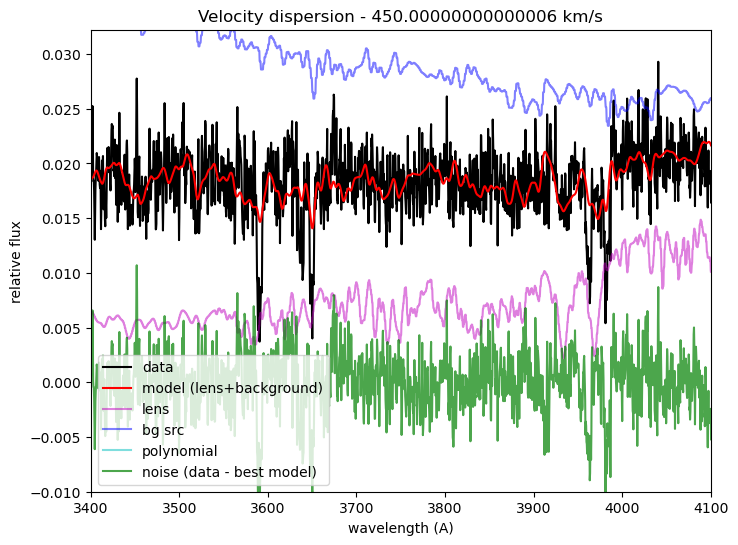

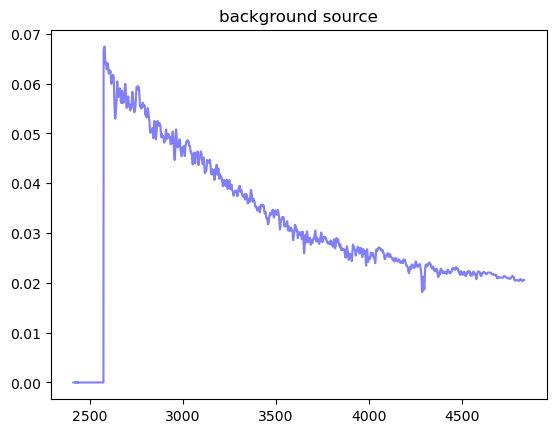

chi2s [0.14239295763086882, 0.0443977432868064, 0.1426944553013519, 0.04439667907980099]


In [78]:
j0330_kinematics.ppxf_central_and_background_spectra_two_component()

In [42]:
#squash

___________________________

In [ ]:
c = 299792.458 # km/s

In [ ]:
vel = 1000
plt.plot(j0330_kinematics.rest_wave[-1300:-600], j0330_kinematics.central_spectrum[-1300:-600], alpha=0.9, c='k')
plt.axvspan(3900, 4000, facecolor='black', alpha=0.5)
plt.plot(j0330_kinematics.rest_wave[-1300:-600]*(1+vel/c), j0330_kinematics.central_spectrum[-1300:-600], c='g', alpha=0.9)

In [ ]:
j0330_kinematics.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [6,
            7,
            14,
            15
            ]squash

In [ ]:
qs = j0330_kinematics.voronoi_binning_output[np.isin(j0330_kinematics.voronoi_binning_output[:,2], questions)]

In [ ]:
plt.imshow(j0330_kinematics.VD_2d, origin='lower')
plt.scatter(qs[:,0], qs[:,1], c=qs[:,2], cmap='sauron')
plt.colorbar()

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j0330_kinematics, file)

# J1112

In [660]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1112+0826'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.273 # lens redshift
z_bs = 0.629
T_exp = 1800*4 # this has been fixed.
lens_center_x,lens_center_y = 64, 131
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [671]:
j1112_kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=background_spectrum_file,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
)

In [672]:
# add the two fucntions above to the instance
j1112_kinematics.log_rebin_background_source_spectrum = \
                        MethodType(log_rebin_background_source_spectrum, j1112_kinematics)
j1112_kinematics.get_templates_two_component = \
                        MethodType(get_templates_two_component, j1112_kinematics)
j1112_kinematics.ppxf_central_and_background_spectra_two_component = \
                        MethodType(ppxf_central_and_background_spectra_two_component, j1112_kinematics)

In [673]:
# get background source redshift
j1112_kinematics.zsource = z_bs

In [674]:
# rebin the central spectrum in log wavelengths and prepare for fitting
j1112_kinematics.log_rebin_central_spectrum()
j1112_kinematics.log_rebin_background_source_spectrum()

lens rest wavves (2377.704777547668, 5129.7329143754905)
bg src rest waves (1753.4695999614073, 3782.9888749081792)


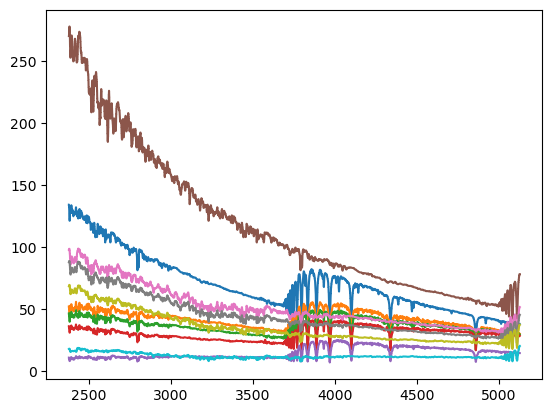

Templates do not go to small enough wavelength to be deredshifted from background source.
bgs templates wavelengths 13865 [2377.83625619 2377.96812712 2378.10000536 ... 5129.11735621 5129.40180871
 5129.68627699]
Adding 0 nans to fill out array size.
bg source wavelengths 13865 [2377.83625619 2377.96812712 2378.10000536 ... 5129.11735621 5129.40180871
 5129.68627699]


In [675]:
j1112_kinematics.get_templates_two_component()

In [676]:
j1112_kinematics.set_up_mask()

In [668]:
0.3154/0.3300

0.9557575757575758

 Best Fit:       Vel     sigma
 comp.  0:        66       310
chi2/DOF: 0.3300; DOF: 1969; degree = 4; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/151


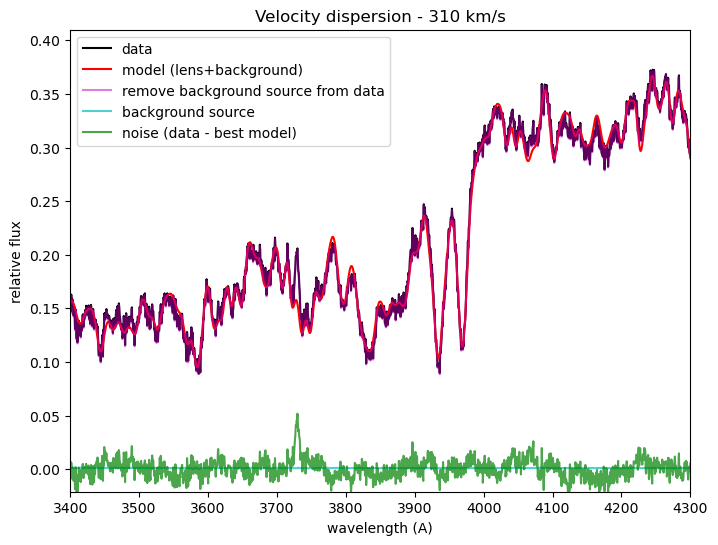

Formal errors:
     dV    dsigma   dh3      dh4
     3.9     4.2
Elapsed time in pPXF: 2.87 s


In [667]:
j1112_kinematics.background_spectrum=j1112_kinematics.background_source_spectrum
j1112_kinematics.get_templates()
j1112_kinematics.ppxf_central_spectrum()

 Best Fit:       Vel     sigma
 comp.  0:        67       315
 comp.  1:        35       450
chi2/DOF: 0.3154; DOF: 1967; degree = 4; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/300


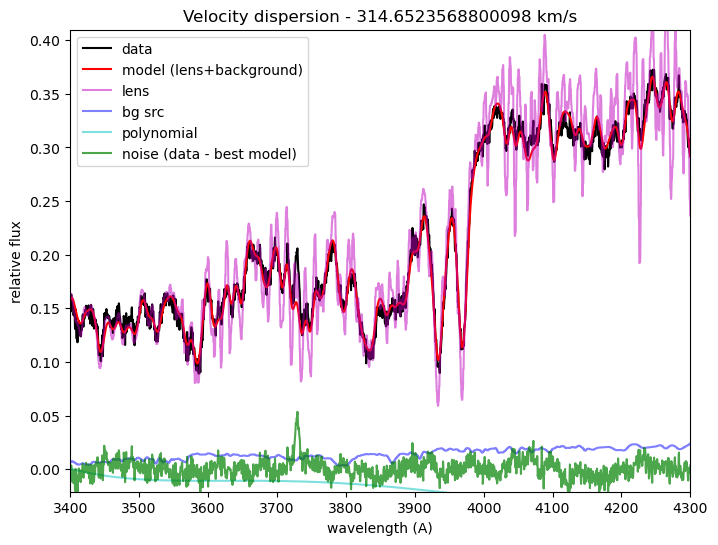

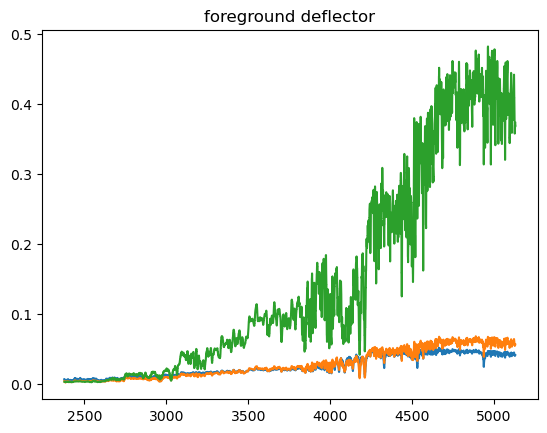

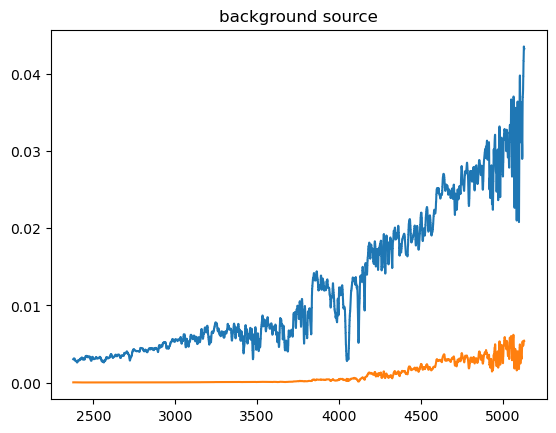

Now fitting the background source arc spectrum
 Best Fit:       Vel     sigma
 comp.  0:       200       199
 comp.  1:         0       100
chi2/DOF: 0.04387; DOF: 1969; degree = 4; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/151


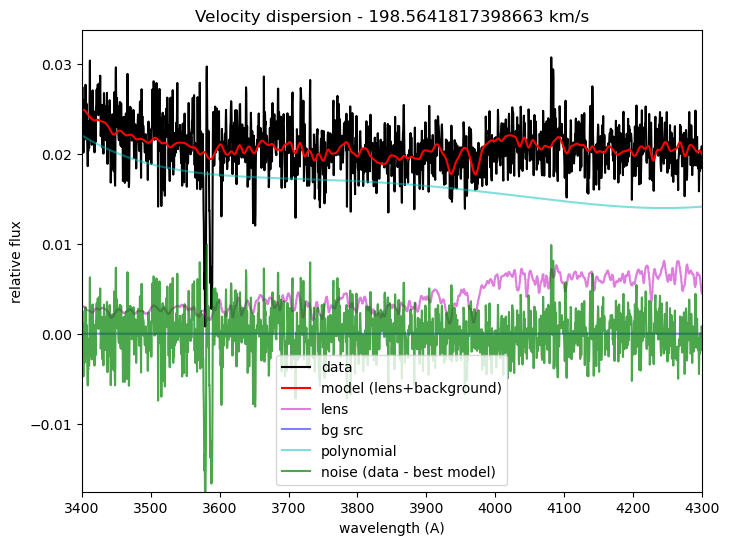

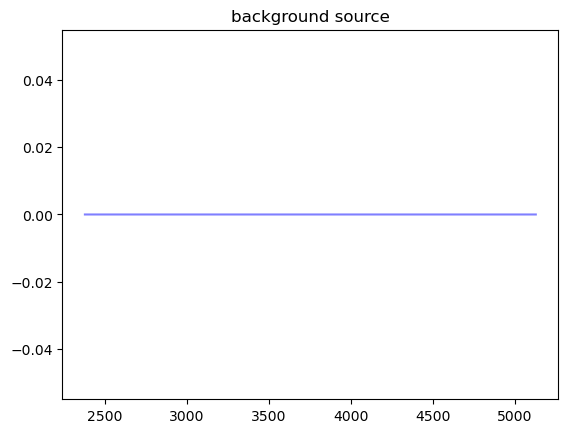

Now fitting the central spectrum
 Best Fit:       Vel     sigma
 comp.  0:        66       310
 comp.  1:         0       100
chi2/DOF: 0.3301; DOF: 1969; degree = 4; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/151


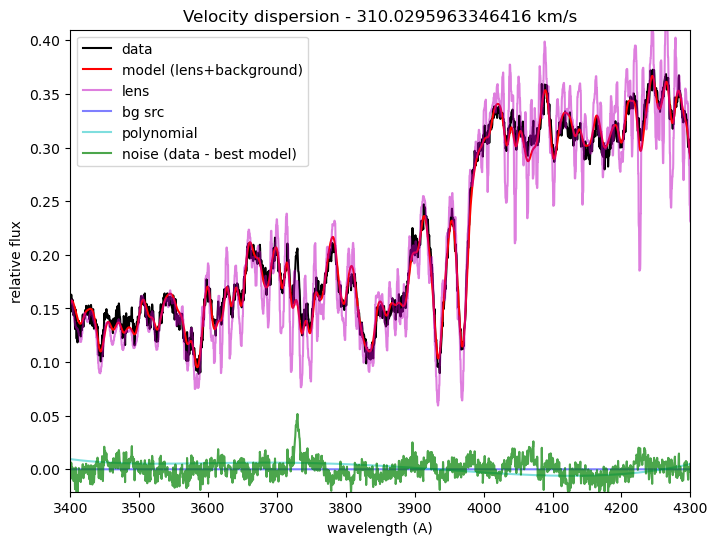

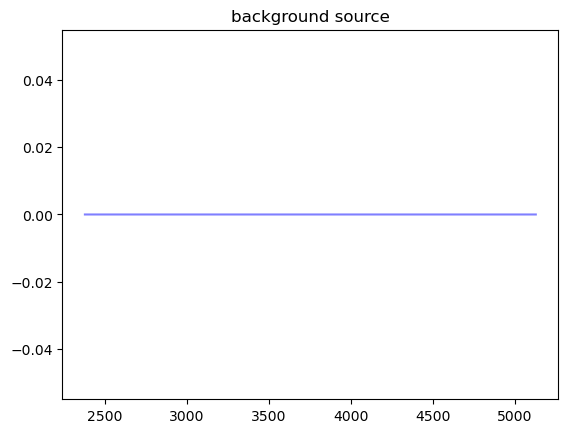

Now fitting the background source arc spectrum
 Best Fit:       Vel     sigma
 comp.  0:       200       199
 comp.  1:         0       100
chi2/DOF: 0.04387; DOF: 1969; degree = 4; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/151


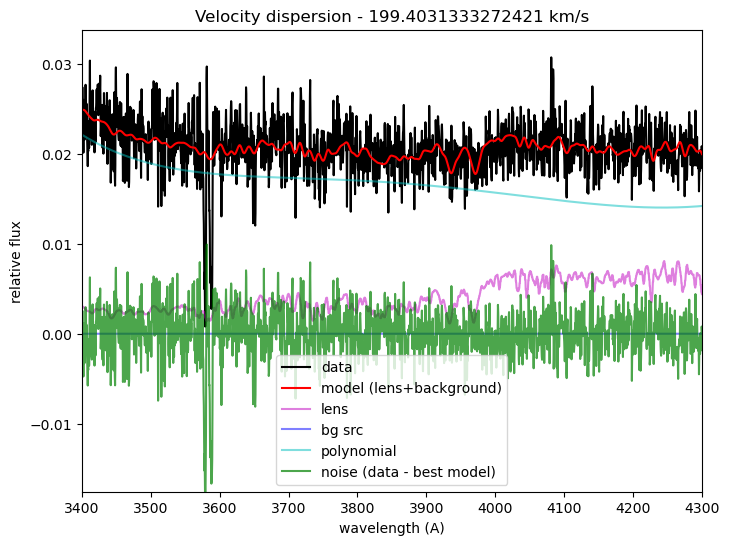

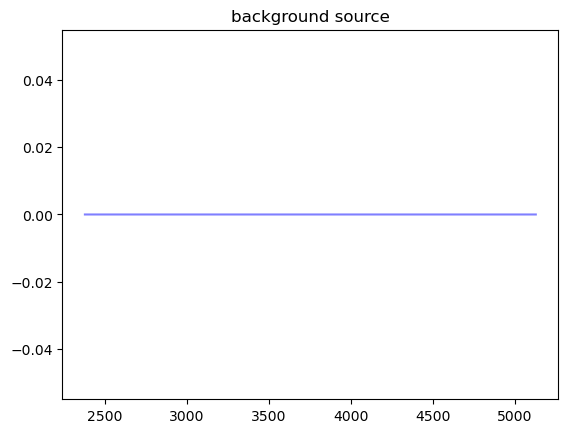

chi2s [0.31539433483428453, 0.04387312017791552, 0.33010677593454907, 0.04387224859964135]


In [677]:
j1112_kinematics.ppxf_central_and_background_spectra_two_component()

In [641]:
a = j1112_kinematics.central_spectrum_ppxf.templates * j1112_kinematics.central_spectrum_ppxf.weights

In [644]:
b = j1112_kinematics.central_spectrum_ppxf.lam_temp

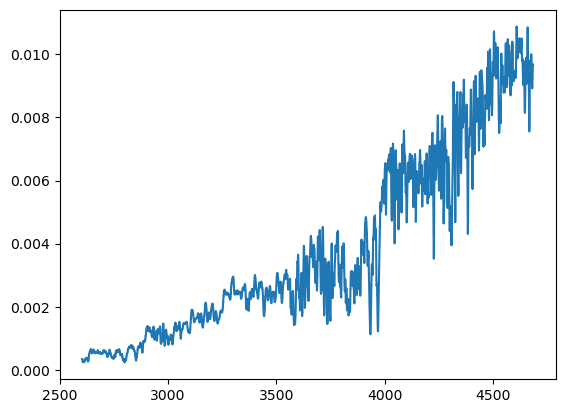

In [648]:
for i in range(a.shape[1]):
    if not np.all(a[:,i]==0):
        plt.plot(b, a[:,i])

In [642]:
a.shape

(10596, 151)

In [ ]:
#squash

In [85]:
j1112_kinematics.zsource-j1112_kinematics.zlens

0.356

In [83]:
18801/13865

1.3560043274432023

_________________

In [ ]:
j1112_kinematics.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1112_kinematics, file)

# J1204

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1204+0358'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.164 # lens redshift
T_exp = 1800*4 # this has been corrected
lens_center_x,lens_center_y = 60, 135
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [ ]:
j1204= slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1204.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [30,
                36,
                43,
                47,
                48,
                49,
                50,
                51,
                53,
                54,
                55,
                69,
                81,
                89,
                111,
                120,
                129,
                133,
                141,
                149,
                150,
                151,
                153,
                154,
                155,
                156,
                157,
                158]

In [ ]:
qs = j1204.voronoi_binning_output[np.isin(j1204.voronoi_binning_output[:,2], questions)]

In [ ]:
q129 = j1204.voronoi_binning_output[j1204.voronoi_binning_output[:,2]==129]
q133 = j1204.voronoi_binning_output[j1204.voronoi_binning_output[:,2]==133]
q158 = j1204.voronoi_binning_output[j1204.voronoi_binning_output[:,2]==158]

In [ ]:
plt.imshow(j1204.VD_2d, origin='lower')
p=plt.scatter(qs[:,0], qs[:,1], c=qs[:,2], cmap='sauron', marker='.')
plt.scatter(q129[:,0], q129[:,1], c='k', marker='>')
plt.scatter(q133[:,0], q133[:,1], c='k', marker='x')
plt.scatter(q158[:,0], q158[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1204, file)

# J1250

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1250+0523'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.232 # lens redshift
T_exp = 1800*3 # this has been corrected
lens_center_x,lens_center_y = 53, 127
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [ ]:
j1250= slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1250.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [26,
                28,
                29,
                31,
                37,
                42,
                45,
                52,
                67,
                88,
                102,
                104,
                107,
                114,
                115,
                116
            ]

In [ ]:
qs = j1250.voronoi_binning_output[np.isin(j1250.voronoi_binning_output[:,2], questions)]
plt.imshow(j1250.VD_2d, origin='lower')
p=plt.scatter(qs[:,0], qs[:,1], c=qs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1250, file)

# J1306

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1306+0600'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.173 # lens redshift
T_exp = 1800*3 + 1500 # corrected #266 * 60
lens_center_x,lens_center_y = 56, 137
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [ ]:
j1306= slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1306.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [7,
                16,
                17,
                23,
                24,
                30,
                31,
                36,
                57,
                61,
                72,
                78,
                89,
                96,
                97,
                99,
                104,
                106,
                107,
                108,
                109,
                110,
                111,
                113,
                114,
                115,
                116,
                117]

In [ ]:
bigger_questions = [24,
                    57,
                    61,
                    97,
                    107,
                    116]

In [ ]:
qs = j1306.voronoi_binning_output[np.isin(j1306.voronoi_binning_output[:,2], questions)]
bqs = j1306.voronoi_binning_output[np.isin(j1306.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1306.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1306, file)

# J1402

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1402+6321'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.205 # lens redshift
T_exp = 1800*4 # corrected
lens_center_x,lens_center_y = 57, 129
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1402 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1402.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [46,
                51,
                53,
                54,
                59,
                66,
                68,
                80,
                83,
                86,
                92,
                95,
                99,
                108,
                150,
                151,
                152,
                153,
                159,
                162,
                168,
                173,
                176,
                177,
                178,
                179,
                180]
bigger_questions=[46,
                  51,
                  54,
                  83,
                  86,
                  92,
                  106,
                  108,
                  159,
                 162]
                                  
qs = j1402.voronoi_binning_output[np.isin(j1402.voronoi_binning_output[:,2], questions)]
bqs = j1402.voronoi_binning_output[np.isin(j1402.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1402.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1402, file)

# Now J1402 with degree 5, to see if it improves the error wiggles.

In [ ]:
j1402.degree=5

In [ ]:
j1402.run_slacs_kcwi_kinematics(plot_bin_fits=True)

# J1531

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1531-0105'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.16 # lens redshift
T_exp = 1200*4 # corrected # I removed frame 32 which was 80 seconds... couldn't find center to make the mosiac... #+ 80*60 #266 * 60
lens_center_x,lens_center_y = 60, 129
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1531 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1531.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [6,
                7,
                18,
                20,
                24,
                25,
                26,
                29,
                30,
                35,
                43,
                49,
                58,
                59,
                61,
                62,
                66,
                67,
                68,
                69,
                70,
                71
            ]
bigger_questions = [25, 43, 59, 61, 62, 66, 67, 69]
                    

In [ ]:
qs = j1531.voronoi_binning_output[np.isin(j1531.voronoi_binning_output[:,2], questions)]
bqs = j1531.voronoi_binning_output[np.isin(j1531.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1531.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1531, file)

# J1538

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1538+5817'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.143 # lens redshift
T_exp = 1800*2 # this has been corrected
lens_center_x,lens_center_y = 58, 119
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1538 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1538.run_slacs_kcwi_kinematics()

In [ ]:
j1538.ppxf_bin_spectra(plot_bin_fits=True)

In [ ]:
questions = [29,
                30,
                 32,
                33,
                37,
                38,
                43,
                46,
                48,
                50,
                54,
                56,
                58,
                69,
                74,
                77,
                78,
                79
                ]
bigger_questions = [29, 32, 33, 38, 50, 54]
qs = j1538.voronoi_binning_output[np.isin(j1538.voronoi_binning_output[:,2], questions)]
bqs = j1538.voronoi_binning_output[np.isin(j1538.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1538.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
j1538.plot_kinematic_maps()

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1538, file)

In [ ]:
del j1204, j1250, j1306, j1402, j1531, j1538

# J1621

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1621+3931'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.245 # lens redshift
T_exp = 1200*6 # corrected
lens_center_x,lens_center_y = 58, 126 #30, 99
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1621 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1621.run_slacs_kcwi_kinematics()

In [ ]:
j1621.ppxf_bin_spectra(plot_bin_fits=True)

In [ ]:
questions = [20,
                22,
                23,
                25,
                26,
                27,
                28,
                38,
                40,
                47,
                51,
                57,
                63,
                66,
                68,
                69
            ]
bigger_questions = [25, 47, 63, 66]
qs = j1621.voronoi_binning_output[np.isin(j1621.voronoi_binning_output[:,2], questions)]
bqs = j1621.voronoi_binning_output[np.isin(j1621.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1621.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
j1621.plot_kinematic_maps()

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1621, file)

# J1627

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1627-0053'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.208 # lens redshift
T_exp = 1800*5 + 960 # corrected #266 * 60
lens_center_x,lens_center_y = 56, 134
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1627 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1627.run_slacs_kcwi_kinematics()

In [ ]:
j1627.plot_kinematic_maps()

In [ ]:
j1627.ppxf_bin_spectra(plot_bin_fits=True)

In [ ]:
questions = [13,
                17,
                18,
                26,
                27,
                28,
                29,
                30,
                31,
                32,
                33,
                34,
                37,
                40,
                41,
                43,
                45,
                47,
                56,
                86,
                89,
                97,
                100,
                101,
                104,
                112,
                113,
                114,
                115,
                116,
                117,
                118,
                119,
                120,
                121,
                122,
                123,
                124,
                125
            ]
bigger_questions = [26, 31, 32, 33, 37, 43, 47, 56, 86, 122]
qs = j1627.voronoi_binning_output[np.isin(j1627.voronoi_binning_output[:,2], questions)]
bqs = j1627.voronoi_binning_output[np.isin(j1627.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1627.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
bin26

In [ ]:
j1627.VD_2d.shape

In [ ]:
bin26[0]

In [ ]:
j1627.VD_2d[bin26[0][0], bin26[0][1]]#, bin26[:,1]]

In [ ]:
j1627.VD_2d[16, 13]

In [ ]:
bin26

In [ ]:
a = j1627.VD_2d.copy()
for i in range(len(bin26)):
    a[bin26[i,0], bin26[i,1]] = 'nan'

In [ ]:
plt.imshow(a, origin='lower', cmap='sauron')
plt.colorbar()


In [ ]:
j1627.plot_kinematic_maps()

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1627, file)

# Try again at higher SN

In [ ]:
SN_hi = 25
j1627_hiSN = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN_hi,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1627_hiSN.run_slacs_kcwi_kinematics()

In [ ]:
plt.imshow(np.nansum(j1627_hiSN.cropped_datacube, axis=0), origin='lower')

In [ ]:
SN_mask = j1627_hiSN.SN_per_AA>2.5
plt.imshow(SN_mask, origin="lower", cmap='gray')
p=plt.imshow(j1627_hiSN.SN_per_AA, origin='lower', alpha=0.9)
plt.colorbar(p)

# 1/10/24 - Try rebinning the bad bins, load the pickle to make it faster.

In [ ]:
# open pickle
obj_name = obj_names[-3]
with open('/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2024_01_09/SDSSJ1627-0053_kinematics_2024_01_09.pkl', 'rb') as file:
    j1627 = pickle.load(file)

In [ ]:
# look at maps
j1627.plot_kinematic_maps()

In [ ]:
# get the highest velocity bin, it's the bad one
bad_bin = np.argmax(j1627.bin_kinematics[:,1])
bad_bin_spectrum = j1627.voronoi_binning_data[bad_bin]
bad_bin_pixels = j1627.voronoi_binning_output[j1627.voronoi_binning_output[:,2]==bad_bin][:,:2]
bad_bin_pixel_indices = np.argwhere(j1627.voronoi_binning_output[:,2]==bad_bin)
bad_bin_pixel_spectra = j1627.cropped_datacube[:,bad_bin_pixels[:,0].astype(int),bad_bin_pixels[:,1].astype(int)]

In [ ]:
# verify it's the right one
plt.imshow(j1627.VD_2d, origin='lower')
plt.scatter(bad_bin_pixels[:,0], bad_bin_pixels[:,1], c='k', marker='.')

In [ ]:
bad_bin_spectra

In [ ]:
bin_y_means = np.zeros(j1627.nbins)
bin_x_means = np.zeros(j1627.nbins)

for i in range(j1627.nbins):
    # get bins and x, y for each pixel
    bin_pixels = j1627.voronoi_binning_output[j1627.voronoi_binning_output[:,2]==i]
    bin_x = bin_pixels[:,0]# - j1627.radius_in_pixels # subtract 21 pixels to center at 0,0
    bin_y = bin_pixels[:,1]# - j1627.radius_in_pixels
    # calculate mean x and y
    mean_x = np.mean(bin_x)
    mean_y = np.mean(bin_y)
    # update array
    bin_x_means[i] = mean_x
    bin_y_means[i] = mean_y

# save bin centers in pixel coordinates
j1627.bin_centers = np.column_stack((bin_x_means, bin_y_means))

In [ ]:
# verify it's the right one
plt.imshow(j1627.VD_2d, origin='lower')
plt.scatter(bad_bin_pixels[:,0], bad_bin_pixels[:,1], c='k', marker='.')
# verify it's the right one
plt.scatter(j1627.bin_centers[:,0], j1627.bin_centers[:,1], c='k', marker='.', s=1)

In [ ]:
# identify the closest bin to each of the pixels in the bad bin
newbins = np.ones(len(bad_bin_pixels), dtype=int)

for i in range(len(bad_bin_pixels)):
    nearbin=0
    nearbin_distance=1000
    for j in range(j1627.nbins):
        if j!=bad_bin:
            bin_center = j1627.bin_centers[j]
            distance = np.sqrt( (bad_bin_pixels[i,0]-bin_center[0])**2 + (bad_bin_pixels[i,1]-bin_center[1])**2 )
            if distance < nearbin_distance:
                nearbin=j
                nearbin_distance=distance
    newbins[i] = nearbin
    
newbins

In [ ]:
new_binning[bad_bin_pixel_indices]

In [ ]:
# Fit these new bins with these pixels added to them
newbin_spectra = np.copy(j1627.voronoi_binning_data)
new_binning = np.copy(j1627.voronoi_binning_output)

for i in range(len(newbins)):
    new_bin = newbins[i]
    new_binning[bad_bin_pixel_indices[i],2] = new_bin
    newbin_index = np.unique(newbins)==new_bin
    new_newbin_pixel = bad_bin_pixels[i]
    pixel_spectrum = bad_bin_pixel_spectra[:,i]
    newbin_spectrum = newbin_spectra[new_bin]
    plt.plot(j1627.rest_wave, newbin_spectrum, c='k')
    newbin_spectrum += pixel_spectrum
    plt.plot(j1627.rest_wave, pixel_spectrum, c='b')
    plt.plot(j1627.rest_wave, newbin_spectrum, c='r')
    plt.xlim(j1627.wave_min, j1630.wave_max)
    plt.ylim(-0.1, 0.1)
    plt.pause(1)

In [ ]:
c = 299792.458 # km/s
import ppxf.ppxf_util as ppxf_util
from kcwi_util import find_nearest

def de_log_rebin(delog_axi, value, lin_axi):
    '''
    :param delog_axi: input the value by np.exp(logLam1)
    :param value: flux at the location of np.exp(logLam1) array
    :param lin_axi: linear space in wavelength that we want to intepolate
    :return: flux at the location of linear space in wavelength
    '''
    inte_sky = interpolate.interp1d(delog_axi, value, bounds_error=False)
    sky_lin = inte_sky(lin_axi)
    return sky_lin

In [ ]:
newbins

### new_bin_kinematics = np.copy(j1627.bin_kinematics)

for i, bin_spectrum in enumerate(newbin_spectra[np.unique(newbins)]):
    galaxy, log_wavelengths, velscale = ppxf_util.log_rebin(j1627.rest_wave_range, bin_spectrum)
    wavelengths = np.exp(log_wavelengths)

    galaxy = galaxy[wavelengths>j1627.wave_min] 
    background_source = j1627.background_spectrum.copy()
    background_source = background_source[wavelengths>j1627.wave_min]
    wavelengths = wavelengths[wavelengths>j1627.wave_min]
    galaxy = galaxy[wavelengths<j1627.wave_max]
    background_source = background_source[wavelengths<j1627.wave_max]
    wavelengths = wavelengths[wavelengths<j1627.wave_max]
    log_wavelengths = np.log(wavelengths)

    lam_range_global_temp = np.array([j1627.global_template_wave.min(), j1627.global_template_wave.max()])
    # after de-redshift, the initial redshift is zero.
    goodPixels = ppxf_util.determine_goodpixels(log_wavelengths, lam_range_global_temp, 0)

    ind_min = find_nearest(wavelengths, j1627.wave_min)
    ind_max = find_nearest(wavelengths, j1627.wave_max)
    mask=goodPixels[goodPixels<ind_max]
    mask = mask[mask>ind_min]
    boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
    mask = mask[boolen]
    boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
    mask = mask[boolen]
    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
    start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
    bounds = [[-500, 500],[50, 450]]
    t = clock()

    noise = np.full_like(galaxy, 0.0047)

    pp = ppxf(j1627.global_template, 
              galaxy, 
              noise, 
              velscale, 
              start, 
              sky=background_source, 
              plot=False,#plot_bin_fits, 
              quiet=j1627.quiet,
                moments=2, 
              goodpixels=mask,
                degree=j1627.degree,
                velscale_ratio=j1627.velscale_ratio,
                lam=wavelengths,
                lam_temp=j1627.global_template_wave,
                )
    #plot the fit
    background = background_source * pp.weights[-1]
    data = pp.galaxy#spectrum_perpixel
    model = pp.bestfit
    log_axis = wavelengths
    lin_axis = np.linspace(j1627.wave_min, j1627.wave_max, data.size)
    back_lin = de_log_rebin(log_axis, background, lin_axis)
    model_lin = de_log_rebin(log_axis, model, lin_axis)
    data_lin = de_log_rebin(log_axis, data, lin_axis)
    noise_lin = data_lin - model_lin
    # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
    plot_ind_min = find_nearest(lin_axis, j1627.wave_min)
    plot_ind_max = find_nearest(lin_axis, j1627.wave_max)
    # make the figure
    plt.figure(figsize=(8,6))
    plt.plot(lin_axis, data_lin, 'k-', label='data')
    plt.plot(lin_axis, model_lin, 'r-', label='model ('
                                                 'lens+background)')
    plt.plot(lin_axis, data_lin - back_lin, 'm-',
             label='remove background source from data', alpha=0.5)
    plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
    plt.plot(lin_axis, noise_lin + np.full_like(back_lin, 0.9e-5), 'g-',
             label='noise (data - best model)', alpha=0.7)
    plt.legend(loc='best')
    plt.ylim(np.nanmin(noise_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
    plt.xlim(j1627.wave_min, j1627.wave_max)
    plt.xlabel('wavelength (A)')
    plt.ylabel('relative flux')
    plt.title(f'Bin {np.unique(newbins)[i]} - Velocity dispersion - {int(pp.sol[1])} km/s')
    plt.show()
    plt.pause(1)
    
    new_bin_kinematics[np.unique(newbins)[i]] = np.hstack( (pp.sol[:2],
                                                           (pp.error*np.sqrt(pp.chi2))[:2],
                                                                      pp.chi2) 
                                                                      )
                                         

In [ ]:
VD_array    =np.zeros(j1627.voronoi_binning_output.shape[0])
dVD_array   =np.zeros(j1627.voronoi_binning_output.shape[0])
V_array     =np.zeros(j1627.voronoi_binning_output.shape[0])
dV_array    =np.zeros(j1627.voronoi_binning_output.shape[0])


for i in range(j1627.voronoi_binning_output.shape[0]):
    num=int(new_binning.T[2][i])
    vd = new_bin_kinematics[num][1]
    dvd = new_bin_kinematics[num][3]
    v = new_bin_kinematics[num][0]
    dv = new_bin_kinematics[num][2]

    VD_array[i]=vd
    dVD_array[i]=dvd
    V_array[i]=v
    dV_array[i]=dv

final=np.vstack((new_binning.T, VD_array, dVD_array, V_array, dV_array))

dim = j1627.radius_in_pixels*2+1

VD_2d=np.zeros((dim, dim))
VD_2d[:]=np.nan
for i in range(final.shape[1]):
    VD_2d[int(final[1][i])][int(final[0][i])]=final[3][i]

dVD_2d=np.zeros((dim, dim))
dVD_2d[:]=np.nan
for i in range(final.shape[1]):
    dVD_2d[int(final[1][i])][int(final[0][i])]=final[4][i]


V_2d=np.zeros((dim, dim))
V_2d[:]=np.nan
for i in range(final.shape[1]):
    V_2d[int(final[1][i])][int(final[0][i])]=final[5][i]

dV_2d=np.zeros((dim, dim))
dV_2d[:]=np.nan
for i in range(final.shape[1]):
    dV_2d[int(final[1][i])][int(final[0][i])]=final[6][i]

In [ ]:
plt.imshow(VD_2d, origin='lower', cmap='sauron')
plt.colorbar()

In [ ]:
plt.imshow(j1627.VD_2d, origin='lower', cmap='sauron')
plt.colorbar()

In [ ]:
j1627.datacube_visualization()

# Make a function for it

In [ ]:
def redistribute_bin (bin_number):
    
    bad_bin_spectrum = j1627.voronoi_binning_data[bin_number]
    bad_bin_pixels = j1627.voronoi_binning_output[j1627.voronoi_binning_output[:,2]==bin_number][:,:2]
    bad_bin_pixel_indices = np.argwhere(j1627.voronoi_binning_output[:,2]==bin_number)
    bad_bin_pixel_spectra = j1627.cropped_datacube[:,bad_bin_pixels[:,0].astype(int),bad_bin_pixels[:,1].astype(int)]

    # verify it's the right one
    plt.imshow(j1627.VD_2d, origin='lower', cmap='sauron')
    plt.colorbar()
    plt.title('VD')
    plt.scatter(bad_bin_pixels[:,0], bad_bin_pixels[:,1], c='k', marker='.', label='bin to be redistributed')
    plt.legend()
    plt.pause(1)
    
    # plot the ppxf fit
    galaxy, log_wavelengths, velscale = ppxf_util.log_rebin(j1627.rest_wave_range, bad_bin_spectrum)
    wavelengths = np.exp(log_wavelengths)

    galaxy = galaxy[wavelengths>j1627.wave_min] 
    background_source = j1627.background_spectrum.copy()
    background_source = background_source[wavelengths>j1627.wave_min]
    wavelengths = wavelengths[wavelengths>j1627.wave_min]
    galaxy = galaxy[wavelengths<j1627.wave_max]
    background_source = background_source[wavelengths<j1627.wave_max]
    wavelengths = wavelengths[wavelengths<j1627.wave_max]
    log_wavelengths = np.log(wavelengths)

    lam_range_global_temp = np.array([j1627.global_template_wave.min(), j1627.global_template_wave.max()])
    # after de-redshift, the initial redshift is zero.
    goodPixels = ppxf_util.determine_goodpixels(log_wavelengths, lam_range_global_temp, 0)

    ind_min = find_nearest(wavelengths, j1627.wave_min)
    ind_max = find_nearest(wavelengths, j1627.wave_max)
    mask=goodPixels[goodPixels<ind_max]
    mask = mask[mask>ind_min]
    boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
    mask = mask[boolen]
    boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
    mask = mask[boolen]
    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
    start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
    bounds = [[-500, 500],[50, 450]]
    t = clock()

    noise = np.full_like(galaxy, 0.0047)

    pp = ppxf(j1627.global_template, 
              galaxy, 
              noise, 
              velscale, 
              start, 
              sky=background_source, 
              plot=False,#plot_bin_fits, 
              quiet=j1627.quiet,
                moments=2, 
              goodpixels=mask,
                degree=j1627.degree,
                velscale_ratio=j1627.velscale_ratio,
                lam=wavelengths,
                lam_temp=j1627.global_template_wave,
                )
    #plot the fit
    background = background_source * pp.weights[-1]
    data = pp.galaxy#spectrum_perpixel
    model = pp.bestfit
    log_axis = wavelengths
    lin_axis = np.linspace(j1627.wave_min, j1627.wave_max, data.size)
    back_lin = de_log_rebin(log_axis, background, lin_axis)
    model_lin = de_log_rebin(log_axis, model, lin_axis)
    data_lin = de_log_rebin(log_axis, data, lin_axis)
    noise_lin = data_lin - model_lin
    # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
    plot_ind_min = find_nearest(lin_axis, j1627.wave_min)
    plot_ind_max = find_nearest(lin_axis, j1627.wave_max)
    # make the figure
    plt.figure(figsize=(8,6))
    plt.plot(lin_axis, data_lin, 'k-', label='data')
    plt.plot(lin_axis, model_lin, 'r-', label='model ('
                                                 'lens+background)')
    plt.plot(lin_axis, data_lin - back_lin, 'm-',
             label='remove background source from data', alpha=0.5)
    plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
    plt.plot(lin_axis, noise_lin + np.full_like(back_lin, 0.9e-5), 'g-',
             label='noise (data - best model)', alpha=0.7)
    plt.legend(loc='best')
    plt.ylim(np.nanmin(noise_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
    plt.xlim(j1627.wave_min, j1627.wave_max)
    plt.xlabel('wavelength (A)')
    plt.ylabel('relative flux')
    plt.title(f'Bin {bin_number} - Velocity dispersion - {int(pp.sol[1])} km/s')
    plt.show()
    plt.pause(1)

    # identify the closest bin to each of the pixels in the bad bin
    newbins = np.ones(len(bad_bin_pixels), dtype=int)

    for i in range(len(bad_bin_pixels)):
        nearbin=0
        nearbin_distance=1000
        for j in range(j1627.nbins):
            if j!=bad_bin:
                bin_center = j1627.bin_centers[j]
                distance = np.sqrt( (bad_bin_pixels[i,0]-bin_center[0])**2 + (bad_bin_pixels[i,1]-bin_center[1])**2 )
                if distance < nearbin_distance:
                    nearbin=j
                    nearbin_distance=distance
        newbins[i] = nearbin
    
    # Fit these new bins with these pixels added to them
    newbin_spectra = np.copy(j1627.voronoi_binning_data)
    new_binning = np.copy(j1627.voronoi_binning_output)

    for i in range(len(newbins)):
        new_bin = newbins[i]
        new_binning[bad_bin_pixel_indices[i],2] = new_bin
        newbin_index = np.unique(newbins)==new_bin
        new_newbin_pixel = bad_bin_pixels[i]
        pixel_spectrum = bad_bin_pixel_spectra[:,i]
        newbin_spectrum = newbin_spectra[new_bin]
        plt.plot(j1627.rest_wave, newbin_spectrum, c='k')
        newbin_spectrum += pixel_spectrum
        plt.plot(j1627.rest_wave, pixel_spectrum, c='b')
        plt.plot(j1627.rest_wave, newbin_spectrum, c='r')
        plt.xlim(j1627.wave_min, j1630.wave_max)
        plt.ylim(-0.1, 0.1)
        plt.title(f'Pixel from bin {bin_number} added to bin {new_bin}')
        plt.pause(1)

    new_bin_kinematics = np.copy(j1627.bin_kinematics)

    for i, bin_spectrum in enumerate(newbin_spectra[np.unique(newbins)]):
        galaxy, log_wavelengths, velscale = ppxf_util.log_rebin(j1627.rest_wave_range, bin_spectrum)
        wavelengths = np.exp(log_wavelengths)

        galaxy = galaxy[wavelengths>j1627.wave_min] 
        background_source = j1627.background_spectrum.copy()
        background_source = background_source[wavelengths>j1627.wave_min]
        wavelengths = wavelengths[wavelengths>j1627.wave_min]
        galaxy = galaxy[wavelengths<j1627.wave_max]
        background_source = background_source[wavelengths<j1627.wave_max]
        wavelengths = wavelengths[wavelengths<j1627.wave_max]
        log_wavelengths = np.log(wavelengths)

        lam_range_global_temp = np.array([j1627.global_template_wave.min(), j1627.global_template_wave.max()])
        # after de-redshift, the initial redshift is zero.
        goodPixels = ppxf_util.determine_goodpixels(log_wavelengths, lam_range_global_temp, 0)

        ind_min = find_nearest(wavelengths, j1627.wave_min)
        ind_max = find_nearest(wavelengths, j1627.wave_max)
        mask=goodPixels[goodPixels<ind_max]
        mask = mask[mask>ind_min]
        boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
        mask = mask[boolen]
        boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
        mask = mask[boolen]
        # Here the actual fit starts. The best fit is plotted on the screen.
        # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
        #
        vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
        start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
        bounds = [[-500, 500],[50, 450]]
        t = clock()

        noise = np.full_like(galaxy, 0.0047)

        pp = ppxf(j1627.global_template, 
                  galaxy, 
                  noise, 
                  velscale, 
                  start, 
                  sky=background_source, 
                  plot=False,#plot_bin_fits, 
                  quiet=j1627.quiet,
                    moments=2, 
                  goodpixels=mask,
                    degree=j1627.degree,
                    velscale_ratio=j1627.velscale_ratio,
                    lam=wavelengths,
                    lam_temp=j1627.global_template_wave,
                    )
        #plot the fit
        background = background_source * pp.weights[-1]
        data = pp.galaxy#spectrum_perpixel
        model = pp.bestfit
        log_axis = wavelengths
        lin_axis = np.linspace(j1627.wave_min, j1627.wave_max, data.size)
        back_lin = de_log_rebin(log_axis, background, lin_axis)
        model_lin = de_log_rebin(log_axis, model, lin_axis)
        data_lin = de_log_rebin(log_axis, data, lin_axis)
        noise_lin = data_lin - model_lin
        # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
        plot_ind_min = find_nearest(lin_axis, j1627.wave_min)
        plot_ind_max = find_nearest(lin_axis, j1627.wave_max)
        # make the figure
        plt.figure(figsize=(8,6))
        plt.plot(lin_axis, data_lin, 'k-', label='data')
        plt.plot(lin_axis, model_lin, 'r-', label='model ('
                                                     'lens+background)')
        plt.plot(lin_axis, data_lin - back_lin, 'm-',
                 label='remove background source from data', alpha=0.5)
        plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
        plt.plot(lin_axis, noise_lin + np.full_like(back_lin, 0.9e-5), 'g-',
                 label='noise (data - best model)', alpha=0.7)
        plt.legend(loc='best')
        plt.ylim(np.nanmin(noise_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
        plt.xlim(j1627.wave_min, j1627.wave_max)
        plt.xlabel('wavelength (A)')
        plt.ylabel('relative flux')
        plt.title(f'Bin {np.unique(newbins)[i]} - Velocity dispersion - {int(pp.sol[1])} km/s')
        plt.show()
        plt.pause(1)

        new_bin_kinematics[np.unique(newbins)[i]] = np.hstack( (pp.sol[:2],
                                                               (pp.error*np.sqrt(pp.chi2))[:2],
                                                                          pp.chi2) 
                                                                          )

    VD_array    =np.zeros(j1627.voronoi_binning_output.shape[0])
    dVD_array   =np.zeros(j1627.voronoi_binning_output.shape[0])
    V_array     =np.zeros(j1627.voronoi_binning_output.shape[0])
    dV_array    =np.zeros(j1627.voronoi_binning_output.shape[0])


    for i in range(j1627.voronoi_binning_output.shape[0]):
        num=int(new_binning.T[2][i])
        vd = new_bin_kinematics[num][1]
        dvd = new_bin_kinematics[num][3]
        v = new_bin_kinematics[num][0]
        dv = new_bin_kinematics[num][2]

        VD_array[i]=vd
        dVD_array[i]=dvd
        V_array[i]=v
        dV_array[i]=dv

    final=np.vstack((new_binning.T, VD_array, dVD_array, V_array, dV_array))

    dim = j1627.radius_in_pixels*2+1

    VD_2d=np.zeros((dim, dim))
    VD_2d[:]=np.nan
    for i in range(final.shape[1]):
        VD_2d[int(final[1][i])][int(final[0][i])]=final[3][i]

    dVD_2d=np.zeros((dim, dim))
    dVD_2d[:]=np.nan
    for i in range(final.shape[1]):
        dVD_2d[int(final[1][i])][int(final[0][i])]=final[4][i]


    V_2d=np.zeros((dim, dim))
    V_2d[:]=np.nan
    for i in range(final.shape[1]):
        V_2d[int(final[1][i])][int(final[0][i])]=final[5][i]

    dV_2d=np.zeros((dim, dim))
    dV_2d[:]=np.nan
    for i in range(final.shape[1]):
        dV_2d[int(final[1][i])][int(final[0][i])]=final[6][i]

    plt.imshow(VD_2d, origin='lower', cmap='sauron')
    plt.colorbar()
    plt.title('New VD map')
    plt.pause(1)

    plt.imshow(j1627.VD_2d, origin='lower', cmap='sauron')
    plt.colorbar()
    plt.title('Old VD map')
    plt.pause(1)

In [ ]:
redistribute_bin(33)

# J1630

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1630+4520'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.248 # lens redshift
T_exp = 1800*4 + 1180 #266 * 60
lens_center_x,lens_center_y = 59, 131
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1630 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1630.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1630, file)

In [ ]:
j1630.ppxf_bin_spectra(plot_bin_fits=True)

# J2303

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ2303+1422'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.155 # lens redshift
T_exp = 1800*3 # corrected
lens_center_x,lens_center_y = 58, 124
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
zlens=z

In [ ]:
j2303 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j2303.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j2303, file)